# Model Analysis

Import statements:

In [1]:
import sys
sys.path.append('src/')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from data_processing.batch_generator import load_train_set, load_test_set, load_pre_data, \
                                            load_train_sample, get_class_weights
from machine_learning.models import DoubleStateTrainAsync, DoubleStateTrainSync, DoubleStateProduction, FeedzaiTrainAsync, FeedzaiTrainSync, FeedzaiProduction, BATCH_SIZE
from machine_learning.pipeline import fit_cycle, compile_model
from pandas import DataFrame
import tensorflow as tf

print(os.getcwd())

/home/nancio/Documents/repos/Thesis


Set random seed:

In [2]:
tf.random.set_seed(42)  # 42 is a random number for the seed generation

Load data:

In [3]:
# For training loop
train_set = load_train_set(batch_size=BATCH_SIZE)

# Samples for analysis
train_sample = load_train_sample(300)

In [4]:
epoch = 0
epoch_sync = 0

---

In [8]:
train_model = DoubleStateTrainAsync(name="double_train_async")
compile_model(train_model, train_set)

Train asynchronous model for a single epoch without validating

In [9]:
for i in range(5):
        train_weight_path = f'src/machine_learning/saved_models/{train_model.name}_{i}'
        train_model.fit(train_set, 
                        epochs=1, 
                        class_weight=get_class_weights(), 
                        verbose='auto', 
                        shuffle=True)

        train_model.save_weights(
                filepath=train_weight_path,
                save_format='h5'
        )

   9/5065 [..............................] - ETA: 19:46 - loss: 0.1677 - binary_accuracy: 0.8247 - true_positives_3: 0.0000e+00 - true_negatives_3: 1900.0000 - false_positives_3: 404.0000 - false_negatives_3: 0.0000e+00

5065/5065 [==============================] - 1420s 280ms/step - loss: 0.5034 - binary_accuracy: 0.9309 - true_positives_3: 1040.0000 - true_negatives_3: 1205908.0000 - false_positives_3: 83098.0000 - false_negatives_3: 6466.0000


---

In [5]:
checkpoint = 5
train_model = FeedzaiTrainAsync(name="Feedzai_train_async")
compile_model(train_model, train_set)

train_model.load_weights(f'src/machine_learning/saved_models/{train_model.name}_{checkpoint-1}', by_name=True)


for i in range(checkpoint, 20):
        train_weight_path = f'src/machine_learning/saved_models/{train_model.name}_{i}'
        train_model.fit(train_set, 
                        epochs=1, 
                        class_weight=get_class_weights(), 
                        verbose='auto', 
                        shuffle=True)

        train_model.save_weights(
                filepath=train_weight_path,
                save_format='h5'
        )

5065/5065 [==============================] - 647s 128ms/step - loss: 0.4007 - binary_accuracy: 0.7987 - true_positives: 4945.0000 - true_negatives: 1030629.0000 - false_positives: 258377.0000 - false_negatives: 2561.0000


In [6]:
checkpoint = 5
train_model = DoubleStateTrainAsync(name="double_train_async")
compile_model(train_model, train_set)

train_model.load_weights(f'src/machine_learning/saved_models/{train_model.name}_{checkpoint-1}', by_name=True)


for i in range(checkpoint, 20):
        train_weight_path = f'src/machine_learning/saved_models/{train_model.name}_{i}'
        train_model.fit(train_set, 
                        epochs=1, 
                        class_weight=get_class_weights(), 
                        verbose='auto', 
                        shuffle=True)

        train_model.save_weights(
                filepath=train_weight_path,
                save_format='h5'
        )

5065/5065 [==============================] - 1216s 240ms/step - loss: 0.4036 - binary_accuracy: 0.7882 - true_positives_1: 5025.0000 - true_negatives_1: 1016900.0000 - false_positives_1: 272106.0000 - false_negatives_1: 2481.0000


# Evalutation

Load test data

In [7]:
pre_test_set = load_pre_data()
test_set = load_test_set()

## Feedzai

In [8]:
production_model = FeedzaiProduction()
compile_model(production_model, test_set)

Iterate through all states of the model to get each performance

In [12]:
for i in range(20):
    model_path = f'src/machine_learning/saved_models/feedzai/async/Feedzai_train_async_{i}'
    production_model.load_weights(model_path, by_name=True)
    production_model.reset_gru()

    production_model.evaluate(pre_test_set, batch_size=1)

    sys.stdout.write("\tTest: ")
    evaluation_results = production_model.evaluate(test_set, batch_size=1)

448990/555719 [=======================>......] - ETA: 54s - loss: 0.5263 - binary_accuracy: 0.8404 - true_positives_1: 266.0000 - true_negatives_1: 377061.0000 - false_positives_1: 69948.0000 - false_negatives_1: 1715.0000

## Double State

In [ ]:
production_model = DoubleStateProduction()
compile_model(production_model, test_set)

In [ ]:
for i in range(20):
    model_path = f'src/machine_learning/saved_models/double/async/double_train_async_{i}'
    production_model.load_weights(model_path, by_name=True)
    production_model.reset_gru()

    production_model.evaluate(pre_test_set, batch_size=1)

    sys.stdout.write("\tTest: ")
    evaluation_results = production_model.evaluate(test_set, batch_size=1)

In [28]:
labels = np.ndarray(shape=(0,))
for element in pre_test_set.as_numpy_iterator():
    labels = np.append(labels, element[1])

plot a sample of model predicitons:

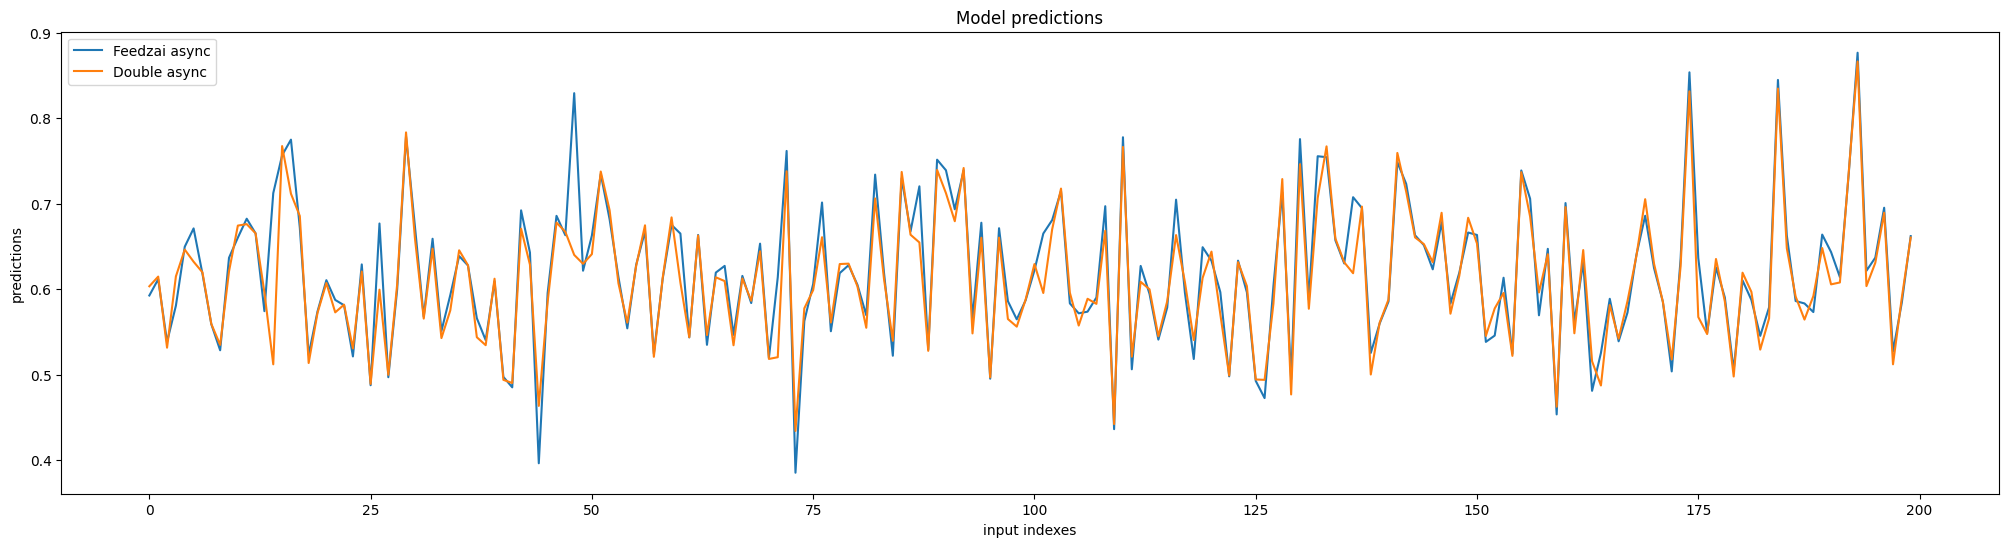

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (25, 6)
mpl.rcParams['axes.grid'] = False

plt.title("Model predictions") 
plt.xlabel("input indexes") 
plt.ylabel("predictions") 

indexes = range(200)
plt.plot(indexes, feedzai_outputs, label = "Feedzai async")
plt.plot(indexes, double_outputs, label = "Double async")

plt.legend()
plt.show()

# NOTE all labels here are ZERO

In [34]:
production_model.load_weights(f'src/machine_learning/saved_models/double_train_async_0', by_name=True)
production_model.reset_gru()
production_model.evaluate(test_set, batch_size=1)


555719/555719 [==============================] - 294s 529us/step - loss: 1.1704 - binary_accuracy: 0.0592 - true_positives_3: 2016.0000 - true_negatives_3: 30902.0000 - false_positives_3: 522672.0000 - false_negatives_3: 129.0000


[1.170398235321045, 0.059234973043203354, 2016.0, 30902.0, 522672.0, 129.0]

In [37]:
production_model.load_weights(f'src/machine_learning/saved_models/Feedzai_train_async_0', by_name=True)
production_model.reset_gru()
production_model.evaluate(test_set, batch_size=1)

     1/555719 [..............................] - ETA: 33:59 - loss: 0.8382 - binary_accuracy: 0.0000e+00 - true_positives_3: 0.0000e+00 - true_negatives_3: 0.0000e+00 - false_positives_3: 1.0000 - false_negatives_3: 0.0000e+00

555719/555719 [==============================] - 302s 543us/step - loss: 1.1704 - binary_accuracy: 0.0592 - true_positives_3: 2016.0000 - true_negatives_3: 30902.0000 - false_positives_3: 522672.0000 - false_negatives_3: 129.0000


[1.170398235321045, 0.059234973043203354, 2016.0, 30902.0, 522672.0, 129.0]